# Imports

In [20]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# AR-HMM

## Definition of the model

In [ ]:
class ARHMM:
    def __init__(self, n_states=3, ar_order=1, n_iter=50):
        self.n_states = n_states
        self.ar_order = ar_order
        self.n_iter = n_iter
    
    # Prepare lagged series
    def _prepare_data(self, X):
        X = np.ravel(X)  # convert in 1D
        Xs = []
        for t in range(self.ar_order, len(X)):
            lagged = X[t-self.ar_order:t][::-1]  # x_{t-1},...,x_{t-p}
            Xs.append(np.hstack([X[t], lagged]))
        return np.array(Xs)
    
    # Fit EM
    def fit(self, X):
        self.X_raw = X
        T = len(X)
        p = self.ar_order
        K = self.n_states
        
        # Initialisation
        self.A = np.full((K,K), 1.0/K)  # transition matrix
        self.mu = np.random.randn(K, p+1) * 0.01  # coeffs AR + bias
        self.sigma2 = np.ones(K) * 0.01
        self.pi = np.full(K, 1.0/K)  # init probs
        
        # Prepare lagged data
        Xs = self._prepare_data(X)
        self.Xs = Xs
        
        for iteration in range(self.n_iter):
            # ----- E-step : forward-backward -----
            T_lag = len(Xs)
            # log likelihoods
            B = np.zeros((T_lag, K))
            for k in range(K):
                pred = Xs[:,1:] @ self.mu[k,1:] + self.mu[k,0]
                B[:,k] = -0.5*np.log(2*np.pi*self.sigma2[k]) - 0.5*(Xs[:,0]-pred)**2/self.sigma2[k]
            
            # Forward
            log_alpha = np.zeros((T_lag, K))
            log_alpha[0] = np.log(self.pi) + B[0]
            for t in range(1, T_lag):
                for j in range(K):
                    log_alpha[t,j] = B[t,j] + np.logaddexp.reduce(log_alpha[t-1] + np.log(self.A[:,j]))
            
            # Backward
            log_beta = np.zeros((T_lag, K))
            for t in range(T_lag-2, -1, -1):
                for i in range(K):
                    log_beta[t,i] = np.logaddexp.reduce(np.log(self.A[i,:]) + B[t+1,:] + log_beta[t+1,:])
            
            # Gamma & Xi
            log_gamma = log_alpha + log_beta
            log_gamma -= log_gamma.max(axis=1, keepdims=True)  # stability
            gamma = np.exp(log_gamma)
            gamma /= gamma.sum(axis=1, keepdims=True)
            
            xi = np.zeros((T_lag-1, K, K))
            for t in range(T_lag-1):
                for i in range(K):
                    for j in range(K):
                        xi[t,i,j] = log_alpha[t,i] + np.log(self.A[i,j]) + B[t+1,j] + log_beta[t+1,j]
                xi[t] = np.exp(xi[t]-np.max(xi[t]))
                xi[t] /= xi[t].sum()
            
            # ----- M-step : update -----
            self.pi = gamma[0]
            self.A = xi.sum(axis=0)
            self.A /= self.A.sum(axis=1, keepdims=True)
            
            for k in range(K):
                W = np.diag(gamma[:,k])
                X_lag = Xs[:,1:]
                y = Xs[:,0]
                # weighthed regression for AR 
                X_aug = np.hstack([np.ones((T_lag,1)), X_lag])
                theta = np.linalg.pinv(X_aug.T @ W @ X_aug) @ (X_aug.T @ W @ y)
                self.mu[k] = theta
                resid = y - X_aug @ theta
                self.sigma2[k] = (gamma[:,k] * resid**2).sum() / gamma[:,k].sum()
        
        print("Fit terminé")
    
    # Prediction of the next step
    def predict_next(self, history):
        p = self.ar_order
        last_obs = np.ravel(history[-p:])  # convert in 1D
        probs = np.zeros(self.n_states)
        preds_states = np.zeros(self.n_states)
        
        for k in range(self.n_states):
            # check that mu[k,1:] has the good size
            assert last_obs.shape[0] == self.mu[k,1:].shape[0], "Mismatch AR order!"
            pred = last_obs @ self.mu[k,1:] + self.mu[k,0]
            preds_states[k] = pred
            probs[k] = 1.0 / np.sqrt(2*np.pi*self.sigma2[k]) * np.exp(-(history[-1]-pred)**2/(2*self.sigma2[k]))
        
        probs /= probs.sum()
        return np.dot(probs, preds_states)

## Creation of the Dataset

In [31]:
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
prices = data["Close"].dropna().values
returns = np.log(prices[1:] / prices[:-1])

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_2433/2887288894.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


## Training

In [32]:
split_idx = int(0.8 * len(returns))
train, test = returns[:split_idx], returns[split_idx:]

arhmm = ARHMM(n_states=3, ar_order=2, n_iter=20)
arhmm.fit(train)

Fit terminé


## Prediction on Test set

In [ ]:
preds = []
history = train.copy()
for t in range(len(test)):
    pred = arhmm.predict_next(history)
    preds.append(pred)
    history = np.append(history, test[t])  # we add the real return for the next step

preds = np.array(preds)

/var/folders/nk/kpj6413n2lj1cln9c1z0_pj80000gn/T/ipykernel_2433/2711395006.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probs[k] = 1.0 / np.sqrt(2*np.pi*self.sigma2[k]) * np.exp(-(history[-1]-pred)**2/(2*self.sigma2[k]))


In [34]:
preds

array([ 9.84917061e-04, -2.51101569e-02,  5.15944900e-04, -1.19350450e-03,
        1.98144269e-03,  2.98750775e-03, -1.02283184e-03,  9.29919139e-04,
        7.69677640e-04,  1.36514696e-03, -7.41404357e-04,  1.77655381e-03,
        9.65809223e-03,  9.18651896e-04, -4.06190360e-04, -3.90809160e-04,
        6.85419857e-04,  1.53238432e-03,  5.64528633e-04,  1.84589310e-03,
       -6.95380144e-03, -9.15465354e-03,  1.93484966e-03,  8.11572139e-05,
        8.32177978e-04, -3.00177784e-04,  3.16335613e-04,  1.06687248e-03,
        1.42460132e-03,  3.65830580e-04, -3.87912834e-04,  1.80247803e-03,
        1.63887492e-03,  7.18220265e-04,  1.76188711e-03,  1.25409623e-03,
        2.49983030e-06, -2.17135358e-04,  1.18310469e-03,  1.19857311e-03,
        4.66912006e-04,  1.69527804e-03,  1.27662746e-03, -1.51154959e-02,
       -2.08948864e-02,  1.62994207e-03,  1.71790723e-03,  3.92335005e-04,
       -2.87141045e-04, -1.39277210e-04, -6.47165809e-04,  1.39006872e-03,
        2.54596260e-04,  

## Visualize

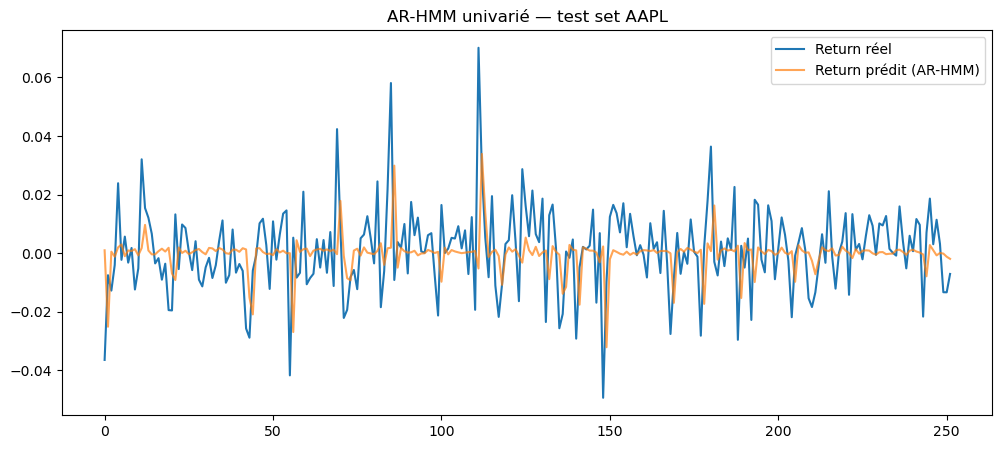

In [35]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Return réel")
plt.plot(preds, label="Return prédit (AR-HMM)", alpha=0.7)
plt.legend()
plt.title("AR-HMM univarié — test set AAPL")
plt.show()

# Local Linear Trend SSM

## Model

In [45]:
class LinearSSM:
    def __init__(self, n_latent=1, n_iter=20):
        self.n_latent = n_latent
        self.n_iter = n_iter
    
    def fit(self, x):
        T = len(x)
        n = self.n_latent
        
        x = x.reshape(-1,1)
        
        # Initialisation des paramètres
        self.A = np.eye(n) + 0.01*np.random.randn(n,n)
        self.C = np.ones((1,n))  # observation matrix
        self.Q = np.eye(n) * 0.01
        self.R = np.array([[0.01]])
        self.z0 = np.zeros((n,1))
        self.P0 = np.eye(n)
        
        for iteration in range(self.n_iter):
            # ---- E-step : Kalman Filter & Smoother ----
            # stocker les filtrés
            z_pred = np.zeros((T,n,1))
            P_pred = np.zeros((T,n,n))
            z_filt = np.zeros((T,n,1))
            P_filt = np.zeros((T,n,n))
            
            # init
            z_pred[0] = self.A @ self.z0
            P_pred[0] = self.A @ self.P0 @ self.A.T + self.Q
            
            # filtre
            for t in range(T):
                if t>0:
                    z_pred[t] = self.A @ z_filt[t-1]
                    P_pred[t] = self.A @ P_filt[t-1] @ self.A.T + self.Q
                # innovation
                y = x[t].reshape(-1,1) - self.C @ z_pred[t]
                S = self.C @ P_pred[t] @ self.C.T + self.R
                K = P_pred[t] @ self.C.T @ np.linalg.inv(S)
                z_filt[t] = z_pred[t] + K @ y
                P_filt[t] = P_pred[t] - K @ self.C @ P_pred[t]
            
            # ---- M-step : mise à jour des paramètres ----
            # estimation A, Q
            sum_num = np.zeros((n,n))
            sum_den = np.zeros((n,n))
            for t in range(1,T):
                sum_num += z_filt[t] @ z_filt[t-1].T
                sum_den += z_filt[t-1] @ z_filt[t-1].T + P_filt[t-1]
            self.A = sum_num @ np.linalg.inv(sum_den)
            
            # Q
            Q_sum = np.zeros((n,n))
            for t in range(1,T):
                res = z_filt[t] - self.A @ z_filt[t-1]
                Q_sum += res @ res.T + P_filt[t] + self.A @ P_filt[t-1] @ self.A.T - self.A @ P_filt[t-1] @ self.A.T
            self.Q = Q_sum / (T-1)
            
            # R
            R_sum = np.zeros((1,1))
            for t in range(T):
                res = x[t].reshape(-1,1) - self.C @ z_filt[t]
                R_sum += res @ res.T
            self.R = R_sum / T
        
        self.z_filt = z_filt
    
    def predict_next(self, last_z=None):
        if last_z is None:
            last_z = self.z_filt[-1]
        return (self.C @ (self.A @ last_z)).item()

## Training

In [46]:
split_idx = int(0.8*len(returns))
train, test = returns[:split_idx], returns[split_idx:]

ssm = LinearSSM(n_iter=20)
ssm.fit(train)

## Prediction

In [47]:
preds = []
last_z = ssm.z_filt[-1]
for t in range(len(test)):
    pred = ssm.predict_next(last_z)
    preds.append(pred)
    # update last_z approx
    last_z = ssm.A @ last_z + ssm.Q @ np.random.randn(ssm.n_latent,1)

preds = np.array(preds)

In [48]:
preds

array([ 7.05739512e-04, -1.20450479e-04,  6.44456282e-05,  4.33719999e-05,
       -2.56890963e-05, -6.20858706e-05,  3.86269721e-06, -6.95320438e-05,
        6.07659890e-05,  9.88147889e-05,  4.61733244e-05,  3.83400941e-05,
        5.32843569e-05, -1.55505415e-05, -9.44022065e-05, -2.86819214e-05,
        7.03440226e-05, -1.10800465e-04, -8.58888149e-06,  4.41919630e-05,
       -5.61956897e-05, -3.71497405e-05, -6.94816747e-05, -3.73476871e-05,
        4.92187295e-05,  5.00209803e-05, -2.25100109e-05,  3.57583254e-05,
       -2.00378982e-05, -3.46755314e-05,  2.58115337e-05, -3.38600865e-05,
       -4.69624331e-05, -1.53582292e-05, -2.25238126e-05, -7.65225946e-05,
        9.77434447e-05,  2.20478826e-05, -4.87951501e-05,  4.30712681e-05,
        2.00307099e-05, -5.44907787e-05, -2.11434033e-06, -2.44550372e-05,
        3.54437601e-05,  1.20909628e-05, -4.20565129e-05, -1.31311991e-05,
        8.01770575e-06, -2.54723156e-05, -5.07597153e-05,  2.98353881e-05,
        4.13267792e-05, -

## Visualize

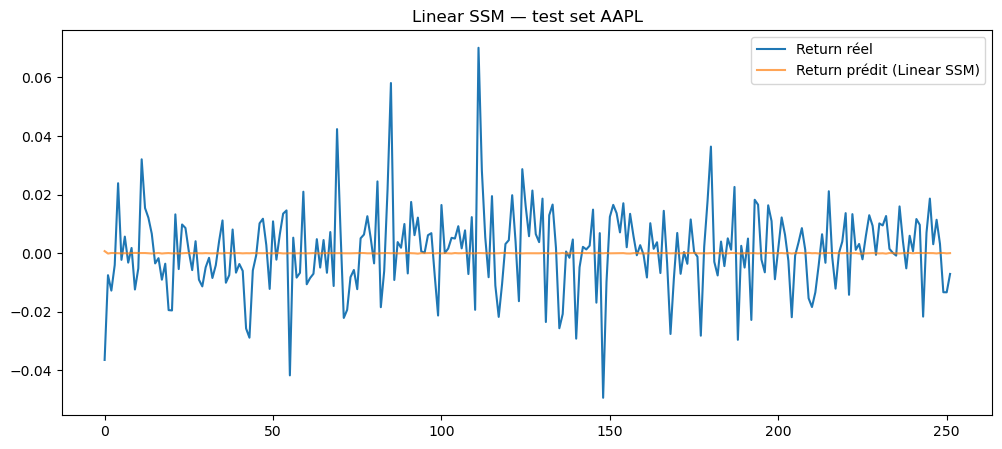

In [51]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Return réel")
plt.plot(preds, label="Return prédit (Linear SSM)", alpha=0.7)
plt.legend()
plt.title("Linear SSM — test set AAPL")
plt.show()

# Multi Factor SSM

## Model

In [97]:
class MultiFactorSSM:
    def __init__(self, n_iter=20):
        self.n_iter = n_iter
    
    def fit(self, x):
        T = len(x)
        x = x.reshape(-1,1)
        
        # États latents : trend, log-vol, cycle
        self.n_latent = 3
        self.A = np.eye(self.n_latent) + 0.01*np.random.randn(self.n_latent,self.n_latent)
        self.Q = np.eye(self.n_latent)*0.01
        self.z0 = np.zeros((self.n_latent,1))
        self.P0 = np.eye(self.n_latent)
        
        # Observation matrix : trend + cycle
        self.C = np.array([[1,0,1]])
        
        # filtre stockage
        self.z_filt = np.zeros((T,self.n_latent,1))
        self.P_filt = np.zeros((T,self.n_latent,self.n_latent))
        
        # EM simplifié
        for it in range(self.n_iter):
            z_pred = np.zeros_like(self.z_filt)
            P_pred = np.zeros_like(self.P_filt)
            
            # Kalman-like filtering
            for t in range(T):
                if t==0:
                    z_pred[t] = self.A @ self.z0
                    P_pred[t] = self.A @ self.P0 @ self.A.T + self.Q
                else:
                    z_pred[t] = self.A @ self.z_filt[t-1]
                    P_pred[t] = self.A @ self.P_filt[t-1] @ self.A.T + self.Q
                
                # observation variance from latent log-vol
                sigma2 = np.exp(z_pred[t,1,0])
                
                # innovation
                y = x[t] - self.C @ z_pred[t]
                S = self.C @ P_pred[t] @ self.C.T + sigma2
                K = P_pred[t] @ self.C.T / S  # gain
                self.z_filt[t] = z_pred[t] + K * y
                self.P_filt[t] = P_pred[t] - K @ self.C @ P_pred[t]
    
    def predict_next(self, last_z=None):
        if last_z is None:
            last_z = self.z_filt[-1]
        pred = self.C @ (self.A @ last_z)
        return pred.item(), np.exp((self.A @ last_z)[1,0])  # return predicted mean & sigma


## Training

In [98]:
split_idx = int(0.8*len(returns))
train, test = returns[:split_idx], returns[split_idx:]

mf_ssm = MultiFactorSSM(n_iter=10)
mf_ssm.fit(train)

## Prediction

In [99]:
preds = []
pred_sigmas = []
last_z = mf_ssm.z_filt[-1]
for t in range(len(test)):
    mean, sigma = mf_ssm.predict_next(last_z)
    preds.append(mean)
    pred_sigmas.append(sigma)
    # update last_z approx : ajouter bruit stochastic vol
    last_z = mf_ssm.A @ last_z + np.random.multivariate_normal(np.zeros(3), mf_ssm.Q).reshape(-1,1)

preds = np.array(preds)
pred_sigmas = np.array(pred_sigmas)

## Visualize

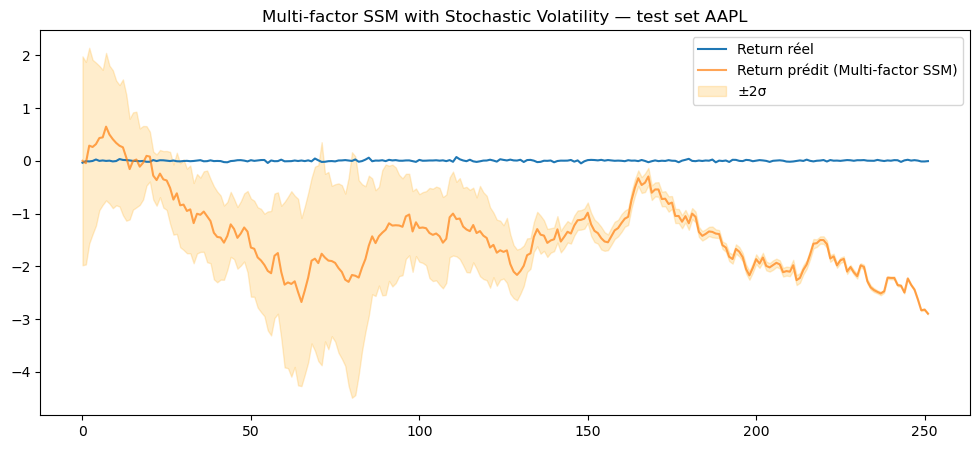

In [100]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Return réel")
plt.plot(preds, label="Return prédit (Multi-factor SSM)", alpha=0.7)
plt.fill_between(np.arange(len(preds)), preds-2*pred_sigmas, preds+2*pred_sigmas,
               color='orange', alpha=0.2, label="±2σ")
plt.legend()
plt.title("Multi-factor SSM with Stochastic Volatility — test set AAPL")
plt.show()

# Extended Kalman Filter

In [106]:
class ExtendedKalmanFilter:
    def __init__(self, Q=None, R=None):
        """
        Q : covariance de l'état (2x2)
        R : variance de l'observation
        """
        self.Q = Q if Q is not None else np.diag([1e-4, 1e-4])
        self.R = R if R is not None else 1e-3
        
    def f(self, z):
        """ Transition non linéaire : random walk """
        return z
    
    def F_jac(self, z):
        """ Jacobienne de f (identité) """
        return np.eye(2)
    
    def h(self, z):
        """ Observation : r = mu + exp(log_sigma) * eps """
        mu, log_sigma = z
        return np.array([mu])  # espérance conditionnelle
    
    def H_jac(self, z):
        """ Jacobienne de h """
        return np.array([[1.0, 0.0]])
    
    def initialize(self, z0, P0=None):
        self.z = z0
        self.P = P0 if P0 is not None else np.eye(2)
        
    def step(self, y):
        """
        Effectue un pas de filtrage EKF
        y : observation (return)
        """
        # ----- Prediction -----
        z_pred = self.f(self.z)
        F = self.F_jac(self.z)
        P_pred = F @ self.P @ F.T + self.Q

        # ----- Mise à jour -----
        H = self.H_jac(z_pred)
        
        y_pred = self.h(z_pred)[0]     # prévision du return
        S = H @ P_pred @ H.T + self.R  # variance innovation
        K = P_pred @ H.T @ np.linalg.inv(S)

        self.z = z_pred + K.flatten() * (y - y_pred)
        self.P = (np.eye(2) - K @ H) @ P_pred

        return self.z, y_pred, S[0, 0]


def fit_ekf(returns):
    ekf = ExtendedKalmanFilter()
    ekf.initialize(z0=np.array([0.0, np.log(0.02)]))

    filtered_mu = []
    filtered_vol = []
    preds = []
    vars_ = []

    for r in returns:
        z, pred, var = ekf.step(r)
        filtered_mu.append(z[0])
        filtered_vol.append(np.exp(z[1]))
        preds.append(pred)
        vars_.append(var)

    return np.array(filtered_mu), np.array(filtered_vol), np.array(preds), np.array(vars_)

In [107]:
mu_filt, vol_filt, preds, vars_ = fit_ekf(returns)

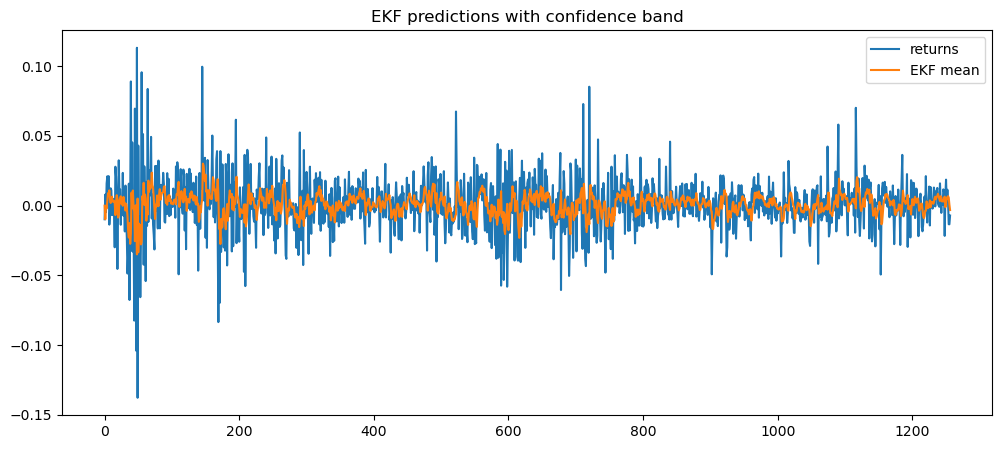

In [112]:
plt.figure(figsize=(12,5))
plt.plot(returns, label="returns")
plt.plot(preds, label="EKF mean")
#plt.fill_between(range(len(preds)),
#                 preds - 2*np.sqrt(vars_),
#                 preds + 2*np.sqrt(vars_),
#                 alpha=0.2)
plt.legend()
plt.title("EKF predictions with confidence band")
plt.show()